In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from keras.preprocessing import image

In [10]:
SHAPE = 80
EPOCHS = 5
NUM_CLASSES = 7

In [4]:
# Configure the training image generator
TRAINING_DIR = "./data/train/"
training_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Configure the validation image generator
VALIDATION_DIR = "./data/test/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Set the image size and batch size for training and validation
# generators 
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(SHAPE,SHAPE),
    class_mode='categorical',
    batch_size=64
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(SHAPE,SHAPE),
    class_mode='categorical',
    batch_size=64
)

Found 7600 images belonging to 7 classes.
Found 1860 images belonging to 7 classes.


In [89]:
AUTOTUNE = tf.data.AUTOTUNE

train_generator = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_generator = validation_generator.cache().prefetch(buffer_size=AUTOTUNE)

AttributeError: 'DirectoryIterator' object has no attribute 'cache'

# Image informations

In [5]:
class_names = list(validation_generator.class_indices.keys())

print(class_names)

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


# Model creation

In [37]:
# Model STARTS HERE
inputs = tf.keras.Input(shape=(SHAPE, SHAPE, 3))

# Entry block
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
x = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

for size in [256]:
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = tf.keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

x = tf.keras.layers.SeparableConv2D(512, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

if NUM_CLASSES == 2:
    activation = "sigmoid"
    units = 1
else:
    activation = "softmax"
    units = NUM_CLASSES

x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(units, activation=activation)(x)

model = tf.keras.Model(inputs, outputs)

tf.keras.utils.plot_model(model, show_shapes=True)

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 rescaling_13 (Rescaling)       (None, 80, 80, 3)    0           ['input_14[0][0]']               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 40, 40, 128)  3584        ['rescaling_13[0][0]']           
                                                                                                  
 batch_normalization_58 (BatchN  (None, 40

# Training

In [38]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=100, validation_data = validation_generator)

model.save("trained_models/emotion_large_adam.h5")

Epoch 1/5
100/100 [==============================] - 23s 179ms/step - loss: 1.8057 - accuracy: 0.2924 - val_loss: 1.9055 - val_accuracy: 0.2581
Epoch 2/5
100/100 [==============================] - 14s 143ms/step - loss: 1.7608 - accuracy: 0.3175 - val_loss: 1.9088 - val_accuracy: 0.2581
Epoch 3/5
100/100 [==============================] - 14s 143ms/step - loss: 1.7198 - accuracy: 0.3410 - val_loss: 1.9174 - val_accuracy: 0.1882
Epoch 4/5
 20/100 [=====>........................] - ETA: 10s - loss: 1.6949 - accuracy: 0.3562

KeyboardInterrupt: 

In [28]:
test_loss, test_acc = model.evaluate(validation_generator)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

30/30 [==============================] - 1s 26ms/step - loss: 2.7249 - accuracy: 0.1774

Test accuracy: 0.17741934955120087

Test loss: 2.724886417388916


# History

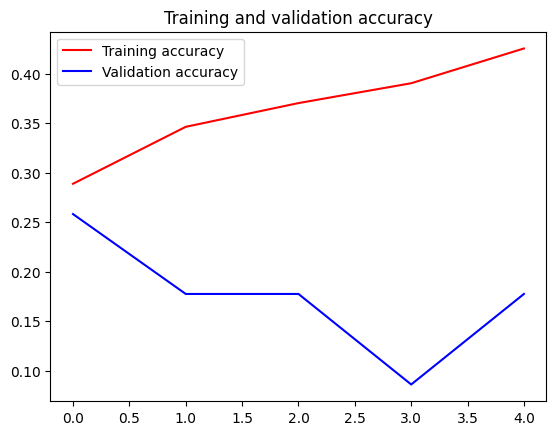

<Figure size 640x480 with 0 Axes>

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# Validation

In [98]:
uploaded = ["./data/uploaded/neutral.jpg"]
img_class = 4

img = tf.keras.utils.load_img(
    uploaded[0], target_size=(SHAPE, SHAPE)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [54]:
predictions_self = model.predict(img_array)
print(predictions_self)

score = tf.nn.softmax(predictions_self[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
[[0. 0. 0. 0. 0. 0. 1.]]
This image most likely belongs to surprise with a 31.18 percent confidence.


In [55]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

predictions = probability_model.predict(img_array)

print(predictions[0])
print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 59ms/step
[0.11470149 0.11470149 0.11470149 0.11470149 0.11470149 0.11470149
 0.31179097]
6


In [16]:
def plot_image(predictions_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label],
                                color=color)
                                )

def plot_value_array(i, predictions_array, true_label):
  plt.grid(False)
  plt.xticks(range(7))
  plt.yticks([])
  thisplot = plt.bar(range(7), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

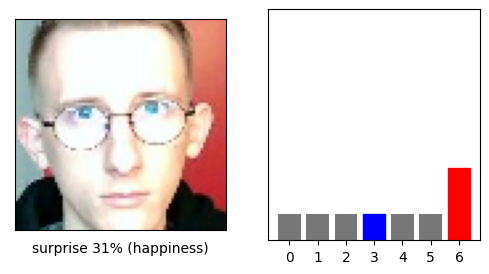

In [57]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(predictions[i], 3, img)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  3 )
plt.show()

# Validate all Data


1/1 [==============================] - 0s 73ms/step
[[3.2113105e-05 6.8080876e-13 6.6473833e-25 3.3066465e-19 9.9996793e-01
  9.1143218e-11 1.4132612e-15]]
1/1 [==============================] - 0s 74ms/step


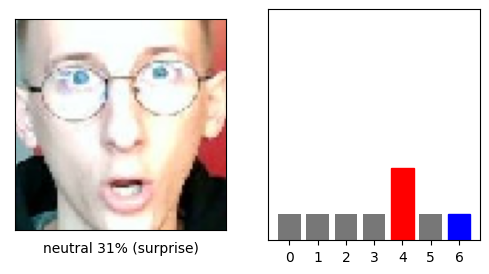

1/1 [==============================] - 0s 14ms/step
[[4.6038931e-05 5.4513875e-13 6.9000224e-25 4.1577502e-19 9.9995399e-01
  2.7456917e-10 1.0351058e-15]]
1/1 [==============================] - 0s 74ms/step


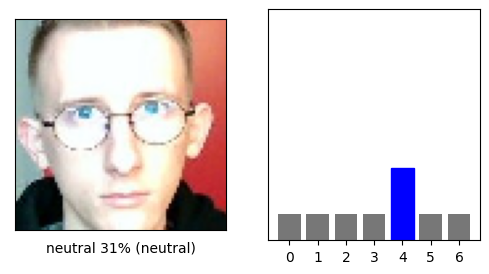

1/1 [==============================] - 0s 18ms/step
[[1.1523818e-02 1.8188821e-06 6.6873083e-12 3.9146459e-09 9.8842931e-01
  4.4920049e-05 1.7157382e-07]]
1/1 [==============================] - 0s 103ms/step


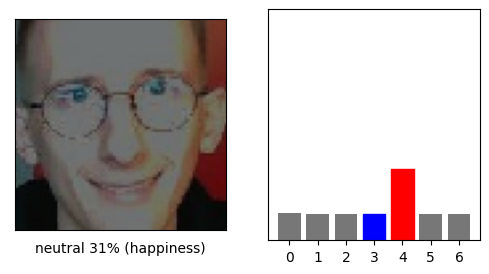

1/1 [==============================] - 0s 17ms/step
[[2.4409172e-04 1.0574633e-09 4.6177735e-19 1.1585172e-14 9.9975580e-01
  7.0521367e-08 4.2462098e-13]]
1/1 [==============================] - 0s 84ms/step


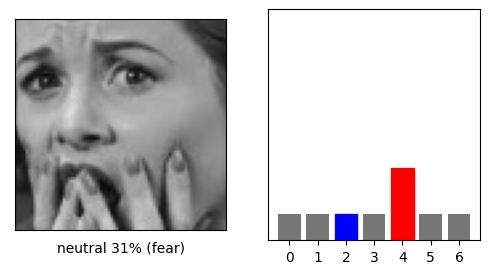

1/1 [==============================] - 0s 14ms/step
[[2.9661812e-04 3.2106121e-10 4.6104258e-17 2.1095943e-14 9.9970335e-01
  1.5017307e-09 9.9152428e-09]]
1/1 [==============================] - 0s 71ms/step


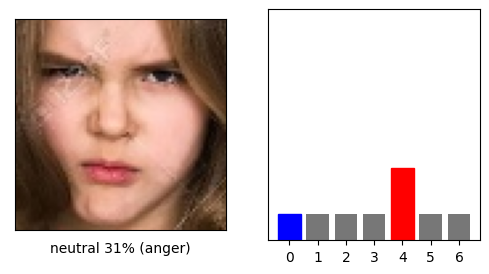

1/1 [==============================] - 0s 14ms/step
[[1.0075248e-05 7.5932538e-13 8.8610395e-24 2.1580033e-19 9.9998987e-01
  2.9341811e-12 2.5593980e-13]]
1/1 [==============================] - 0s 72ms/step


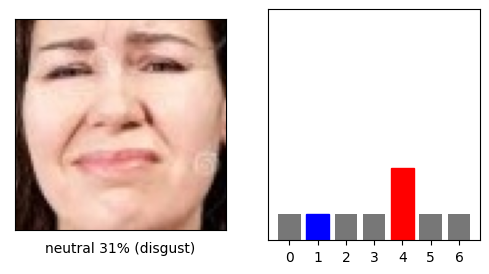

1/1 [==============================] - 0s 19ms/step
[[1.6237305e-02 4.2441137e-08 1.6602537e-12 3.2181730e-10 9.8376012e-01
  1.6870218e-06 9.6373356e-07]]
1/1 [==============================] - 0s 69ms/step


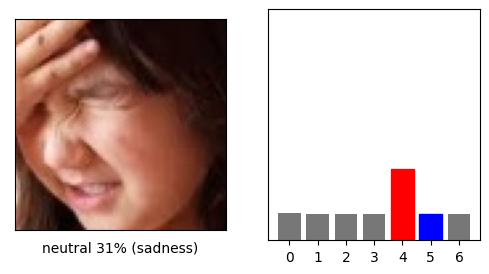

1/1 [==============================] - 0s 16ms/step
[[1.1099495e-03 6.0506694e-10 1.4214165e-14 3.8868520e-13 9.9888986e-01
  8.8931920e-09 1.9837567e-07]]
1/1 [==============================] - 0s 72ms/step


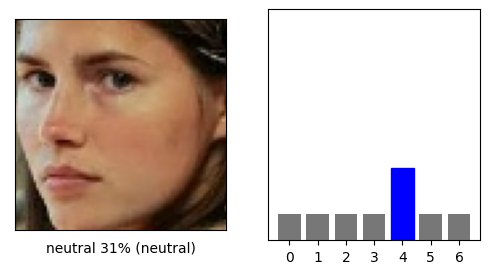

In [30]:
uploaded = [
    "./data/uploaded/suprised.jpg",
    "./data/uploaded/neutral.jpg",
    "./data/uploaded/happy.jpg",
    "./data/uploaded/fear12.jpg",
    "./data/uploaded/anger1.jpg",
    "./data/uploaded/disgust1.jpg",
    "./data/uploaded/sadness1.jpg",
    "./data/uploaded/neutral6.jpg"
]
# 0: Anger, 1: Disgust, 2: Fear, 3: Happy, 4: Neutral, 5: Sad, 6: Surprise
img_class = [6, 4, 3, 2, 0, 1, 5, 4]
# model = tf.keras.models.load_model("trained_models/emotion_NAdam.h5")

img = []
img_array = []
predictions_self = []

for i in range(len(uploaded)):
    img.append(tf.keras.utils.load_img(
        uploaded[i], target_size=(SHAPE, SHAPE)
    ))
    img_array.append(tf.keras.utils.img_to_array(img[i]))
    img_array[i] = tf.expand_dims(img_array[i], 0) # Create a batch
    predictions_self.append(model.predict(img_array[i]))
    print(predictions_self[i])

    score = tf.nn.softmax(predictions_self[i])

    # print(
    #     "This image most likely belongs to {} with a {:.2f} percent confidence."
    #     .format(class_names[np.argmax(score)], 100 * np.max(score))
    # )

    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

    predictions = probability_model.predict(img_array[i])

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(predictions[0], img_class[i], img[i])
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[0],  img_class[i])
    plt.show()

    
    